You heard the hype, right? Machine learning and more specifically "Deep Learning" is the thing right now. But what is Deep Learning all about? Let's find out what Deep Learning is all about and get our feet wet by building Neural Network for handwritten digit classification using 3 different Python frameworks (Theano, TensorFlow and Keras).

# What is Deep Learning?

First, try to watch this demo and be amazed:

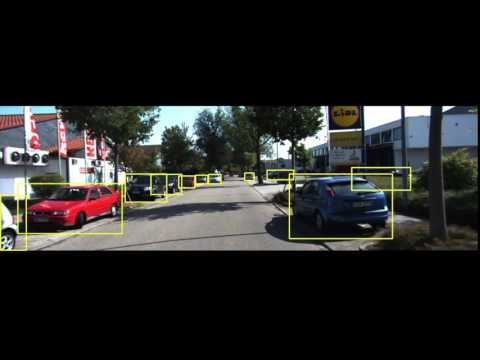

In [10]:
from IPython.display import YouTubeVideo

YouTubeVideo("HJ58dbd5g8g", width=640, height=480)

Ok, you got me! I don't really know and for that matter, nobody really does. But that is not really useful answer now, is it? Let's try that again: Deep Learning is a branch of Machine Learning that tries to move us closer to AI (or General AI). One can simplify things a bit and say: an Artificial Neural Network (ANN) with more than 1 hidden layer. Let's take a look at one ANN:

<img src="http://neuralnetworksanddeeplearning.com/images/tikz41.png" style="width: 520px;">

<h5 align="center">Image courtesy of <a href="http://neuralnetworksanddeeplearning.com" target="_blank">Neural Networks and Deep Learning</a></h5>

A layer in ANN consists of a bunch of neurons. To make a network you stack several layers and connect them in some way (yes, there are different types of connections you can create). In this example, we have input layer with 8 neurons, 3 hidden layers with 9 neurons each and the output layer is comprised of 4 neurons.

# Why Deep Learning is powerful/popular?

One hypothesis would be that big companies like Google, Facebook, Microsoft are constantly talking/showing demos about Deep Learning, but more importantly:

* The end of feature engineering? Automatically tries to learn good features or representations instead of manually creating them.
* Automatic hierarchical representation? It tries to learn multiple levels of representation from raw data.

## What is the cost for all this?

Large amounts of data (not necessarily labeled) are typically needed in order to really hit the sweet spot and get benefits from using Deep Learning. Handcrafted features can still be really useful.

# Who uses Deep Learning and for what?

### Automatic Machine Translation

The task here is simple (or so it seems at first): given a word, phrase, sentence or whole document in let's say, French, translate it into English. How hard can it be? Some humans are pretty good at it, right? But what if you had an instant translator in your pocket, everywhere you go? Furthermore, what if it can translate from images? Well, that seems possible with Deep Learning:

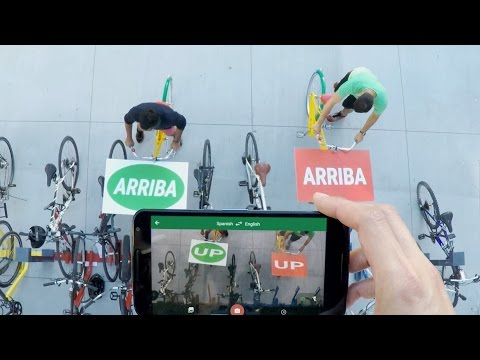

In [12]:
YouTubeVideo("06olHmcJjS0", width=640, height=480)

#### Read more

* [Sequence to Sequence Learning with Neural Networks, 2014](http://arxiv.org/pdf/1409.3215v3.pdf)
* [Deep Neural Networks in Machine Translation: An Overview, 2015](http://www.nlpr.ia.ac.cn/cip/ZongPublications/2015/IEEE-Zhang-8-5.pdf)

### Deep Reinforcement Learning is used to play games

Like playing Atari only from screen pixels and beating humans on Go

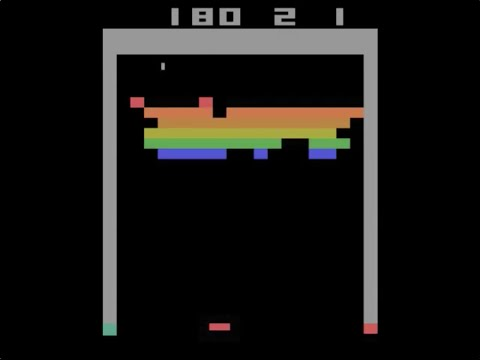

In [11]:
YouTubeVideo("TmPfTpjtdgg", width=640, height=480)

Google's DeepMind created AlphaGo that beat human master at the game Go.

#### Read more

* [Playing Atari with Deep Reinforcement Learning, 2013](http://arxiv.org/pdf/1312.5602v1.pdf)
* [Human-level control through deep reinforcement learning, 2015](https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf)
* [Mastering the game of Go with deep neural networks and tree search, 2016](https://vk.com/doc-44016343_437229031?dl=56ce06e325d42fbc72)

# Becoming Deep Learning ninja

Let's start by preparing the environment you need. You can install all libraries below using standard `pip install`. With one exception (of course) - TensorFlow.

In [1]:
%load_ext watermark

In [2]:
%watermark -v -p numpy,seaborn,matplotlib,pandas,theano,tensorflow,keras

CPython 3.5.1
IPython 5.1.0

numpy 1.11.1
seaborn 0.7.1
matplotlib 1.5.1
pandas 0.18.1
theano 0.8.2
tensorflow 0.10.0rc0
keras 1.0.8


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import theano
import theano.tensor as T
import pickle
import gzip
import os
import sys
import timeit

from pylab import rcParams
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='ticks', palette='Spectral', font_scale=1.5)

material_palette = ["#4CAF50", "#2196F3", "#9E9E9E", "#FF9800", "#607D8B", "#9C27B0"]
sns.set_palette(material_palette)
rcParams['figure.figsize'] = 16, 8

plt.xkcd();
random_state = 42
np.random.seed(random_state);

# Setup MNIST data

In [4]:
dataset = "data/mnist.pkl.gz"

with gzip.open(dataset, 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
train_x, train_y = train_set
valid_x, valid_y = valid_set
test_x, test_y = test_set

# Network parameters

In [5]:
input_size = 28 * 28 # MNIST data input (img shape: 28*28)
hidden_units = 512
output_size = 10 # MNIST data classes (digits 0-9)
batch_size = 128
train_epochs = 20

# Theano

In [6]:
train_x_shared = theano.shared(value=np.asarray(train_x, dtype='float32'), name='train_x')
train_y_shared = theano.shared(value=np.asarray(train_y, dtype='int32'), name='train_y')

In [7]:
class HiddenLayer:
    
    def __init__(self, data, input_size, output_size, weights=None, biases=None, activation=T.tanh):
        self.data = data
        self.input_size = input_size
        self.output_size = output_size
        self.activation=activation
        
        if weights is None:
            w_values = np.asarray(np.random.uniform(
                    low=-np.sqrt(6. / (input_size + output_size)),
                    high=np.sqrt(6. / (input_size + output_size)),
                    size=(input_size, output_size)), dtype=theano.config.floatX)
            if activation == theano.tensor.nnet.sigmoid or activation == theano.tensor.nnet.hard_sigmoid or activation == theano.tensor.nnet.ultra_fast_sigmoid:
                w_values *= 4

            weights = theano.shared(value=w_values, name='weights')

        if biases is None:
            b_values = np.zeros((output_size,), dtype=theano.config.floatX)
            biases = theano.shared(value=b_values, name='biases')

        self.weights = weights
        self.biases = biases

        self.output = T.dot(data, self.weights) + self.biases
        if activation is not None:
            self.output = activation(self.output)
        
        self.params = [self.weights, self.biases]

In [8]:
class SoftmaxLayer:
    
    def __init__(self, data, input_size, output_size):
        self.weights = theano.shared(value=np.zeros((input_size, output_size), 
                                                dtype=theano.config.floatX), name='weights')
        self.biases = theano.shared(value=np.zeros((output_size,),
                                                dtype=theano.config.floatX), name='biases')
        
        self.p_y_given_x = T.nnet.softmax(T.dot(data, self.weights) + self.biases)
        
        self.y_pred = T.argmax(self.p_y_given_x, axis=1)
        self.params = [self.weights, self.biases]
        
    def negative_log_likelihood(self, y):
        return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])

In [9]:
class MLP:
     def __init__(self, data, input_size, hidden_layer_size, output_size):
        self.hidden_layer = HiddenLayer(
            data, input_size=input_size, output_size=hidden_layer_size,
            activation=T.tanh)
        
        self.softmax_layer = SoftmaxLayer(
            data=self.hidden_layer.output,
            input_size=hidden_layer_size, output_size=output_size)
        
        self.negative_log_likelihood = self.softmax_layer.negative_log_likelihood
        
        self.params = self.hidden_layer.params + self.softmax_layer.params

In [10]:
learning_rate = 0.01

index = T.lscalar()
x = T.fmatrix('x')
y = T.ivector('y')

classifier = MLP(data=x, input_size=input_size, hidden_layer_size=hidden_units, output_size=output_size)

cost = classifier.negative_log_likelihood(y)

updates = [(param, param - learning_rate * T.grad(cost, param) ) for param in classifier.params]

train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_x_shared[index * batch_size: (index + 1) * batch_size],
            y: train_y_shared[index * batch_size: (index + 1) * batch_size]
        }
    )

predict_labels = theano.function(inputs=[x], outputs=classifier.softmax_layer.y_pred)

In [11]:
number_of_minibatches = len(train_x) / batch_size

def compute_accurarcy(dataset_x, dataset_y): 
    predictions = predict_labels(dataset_x)
    errors = sum(predictions != dataset_y) #Number of errors
    accurarcy = 1 - errors/float(len(dataset_y))
    return accurarcy

for epoch in range(train_epochs):
    for idx in range(0, int(number_of_minibatches)):
        train_model(idx)

    accurarcy_valid = compute_accurarcy(valid_x, valid_y)
    accurarcy_test = compute_accurarcy(test_x, test_y)

    print("epoch %d: Accurarcy on validation: %f, accurarcy on test: %f" % (epoch + 1, accurarcy_valid, accurarcy_test))

epoch 1: Accurarcy on validation: 0.840600, accurarcy on test: 0.830900
epoch 2: Accurarcy on validation: 0.872900, accurarcy on test: 0.866800
epoch 3: Accurarcy on validation: 0.886700, accurarcy on test: 0.881400
epoch 4: Accurarcy on validation: 0.894000, accurarcy on test: 0.889500
epoch 5: Accurarcy on validation: 0.898400, accurarcy on test: 0.894500
epoch 6: Accurarcy on validation: 0.901900, accurarcy on test: 0.898500
epoch 7: Accurarcy on validation: 0.905200, accurarcy on test: 0.900700
epoch 8: Accurarcy on validation: 0.907100, accurarcy on test: 0.902200
epoch 9: Accurarcy on validation: 0.909600, accurarcy on test: 0.906200
epoch 10: Accurarcy on validation: 0.911400, accurarcy on test: 0.907200
epoch 11: Accurarcy on validation: 0.912300, accurarcy on test: 0.909300
epoch 12: Accurarcy on validation: 0.913900, accurarcy on test: 0.911200
epoch 13: Accurarcy on validation: 0.915000, accurarcy on test: 0.913000
epoch 14: Accurarcy on validation: 0.915700, accurarcy on te

# TensorFlow

In [12]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
mnist = input_data.read_data_sets('data/mnist_tf', one_hot=True)

Extracting data/mnist_tf/train-images-idx3-ubyte.gz
Extracting data/mnist_tf/train-labels-idx1-ubyte.gz
Extracting data/mnist_tf/t10k-images-idx3-ubyte.gz
Extracting data/mnist_tf/t10k-labels-idx1-ubyte.gz


In [13]:
learning_rate = 0.001

n_hidden_1 = int(hidden_units / 2)
n_hidden_2 = int(hidden_units / 2)

x = tf.placeholder("float", [None, input_size])
y = tf.placeholder("float", [None, output_size])


def multilayer_perceptron(x, weights, biases):
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    return tf.matmul(layer_2, weights['out']) + biases['out']

weights = {
    'h1': tf.Variable(tf.random_normal([input_size, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, output_size]))
}
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([output_size]))
}

model = multilayer_perceptron(x, weights, biases)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(model, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(model, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as s:
    s.run(tf.initialize_all_variables())

    for i in range(20000):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        s.run(optimizer, feed_dict={x: batch_x, y: batch_y})

        if i % 1000 == 0:
            train_accuracy = accuracy.eval(feed_dict={x: batch_x, y: batch_y})
            print('step {0}, training accuracy {1}'.format(i, train_accuracy))
    print('test accuracy {0}'.format(accuracy.eval(feed_dict={x: mnist.test.images, y: mnist.test.labels})))

step 0, training accuracy 0.1171875
step 1000, training accuracy 0.890625
step 2000, training accuracy 0.921875
step 3000, training accuracy 0.96875
step 4000, training accuracy 0.9921875
step 5000, training accuracy 0.9765625
step 6000, training accuracy 0.9765625
step 7000, training accuracy 0.9921875
step 8000, training accuracy 0.9921875
step 9000, training accuracy 1.0
step 10000, training accuracy 1.0
step 11000, training accuracy 1.0
step 12000, training accuracy 1.0
step 13000, training accuracy 1.0
step 14000, training accuracy 1.0
step 15000, training accuracy 1.0
step 16000, training accuracy 1.0
step 17000, training accuracy 1.0
step 18000, training accuracy 1.0
step 19000, training accuracy 1.0
test accuracy 0.9575999975204468


# Keras

In [14]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

X_train = train_x.astype('float32')
X_test = test_x.astype('float32')
X_valid = valid_x.astype('float32')
X_train /= 255
X_test /= 255
X_valid /= 255

Y_train = np_utils.to_categorical(train_y, output_size)
Y_test = np_utils.to_categorical(test_y, output_size)
Y_valid = np_utils.to_categorical(valid_y, output_size)

model = Sequential()
model.add(Dense(hidden_units, input_shape=(input_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, nb_epoch=train_epochs,
                    verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_valid, Y_valid, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Using Theano backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           401920      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 512)           0           dense_1[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 512)           0           activation_1[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      dropout_1[0][0]                  
___________________________________________________________________________________________